In [103]:
'''Visualization of the filters of VGG16, via gradient ascent in input space.
This script can run on CPU in a few minutes (with the TensorFlow backend).
Results example: http://i.imgur.com/4nj4KjN.jpg
'''
from __future__ import print_function

from scipy.misc import imsave
import numpy as np
import time
from keras.applications import *
from keras import backend as K

from keras.models import load_model
import os
%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow, imread

In [71]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# build the VGG16 network with ImageNet weights
# dimensions of the generated pictures for each filter.
'''
img_width = 128
img_height = 128
model = vgg16.VGG16(weights='imagenet', include_top=False)
model.summary()
'''
# load my model
# dimensions of the generated pictures for each filter.

img_width = 66
img_height = 200
model_path = os.getcwd() + '/models/udacity_model.hdf5'
model = load_model(model_path)
model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
activation_9 (Activation)    (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
activation_10 (Activation)   (None, 14, 47, 36)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
activation_11 (Activation)   (None, 5, 22, 48)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712  

In [77]:
# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
# layer_name = 'block5_conv1'
layer_name = 'conv2d_9'
n = int(np.sqrt(layer_dict[layer_name].output_shape[-1]))
print('Number of filters: ', layer_dict[layer_name].output_shape[-1])
print(model.output)

Number of filters:  64
Tensor("dense_8_14/BiasAdd:0", shape=(?, 1), dtype=float32)


In [78]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

num_filters = layer_dict[layer_name].output_shape[-1]
kept_filters = []
for filter_index in range(0, num_filters):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])
    
    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))



Processing filter 0


InvalidArgumentError: You must feed a value for placeholder tensor 'dropout_2/keras_learning_phase' with dtype bool
	 [[Node: dropout_2/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'dropout_2/keras_learning_phase', defined at:
  File "/home/john/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/john/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/john/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/john/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/john/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/john/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/john/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/john/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/john/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/john/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/john/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/john/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/john/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/john/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-f06990bdc641>", line 32, in <module>
    model = load_model(model_path)
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/models.py", line 232, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/models.py", line 293, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/layers/__init__.py", line 46, in deserialize
    printable_module_name='layer')
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/utils/generic_utils.py", line 141, in deserialize_keras_object
    return cls.from_config(config['config'])
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/models.py", line 1190, in from_config
    model.add(layer)
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/models.py", line 455, in add
    output_tensor = layer(self.outputs[0])
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 554, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/layers/core.py", line 111, in call
    training=training)
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2403, in in_train_phase
    training = learning_phase()
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 102, in learning_phase
    name='keras_learning_phase')
  File "/home/john/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1507, in placeholder
    name=name)
  File "/home/john/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1997, in _placeholder
    name=name)
  File "/home/john/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/john/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/john/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'dropout_2/keras_learning_phase' with dtype bool
	 [[Node: dropout_2/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [74]:
# we will stich the best n^2 filters on an n x n grid (but no more than 64..)
# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top n filters.
n = min(8, int(np.sqrt(len(kept_filters))))
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our n x n filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
model_name = 'ud_model'
imsave('./visualizations/stitched_filters_%dx%d_%s.png' % (n, n, model_name), stitched_filters)

# Output Optimization

In [131]:
from keras import applications

'''
# build the VGG16 network
model = applications.VGG16(include_top=False,
                           weights='imagenet')
model.summary()
input_img = model.input
img_width = 128
img_height = 128
'''
img_width = 66
img_height = 200
model_path = os.getcwd() + '/models/udacity_model.hdf5'
model = load_model(model_path)
input_img = model.input
model.summary()
from keras.models import *
model = Model(model)
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
activation_9 (Activation)    (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
activation_10 (Activation)   (None, 14, 47, 36)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
activation_11 (Activation)   (None, 5, 22, 48)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
__________

TypeError: __init__() missing 1 required positional argument: 'outputs'

In [127]:
from keras import backend as K

layer_name = 'conv2d_10'
filter_index = 33 # can be any integer from 0 to 511, as there are 512 filters in that layer

# build a loss function that maximizes the activation
# of the nth filter of the layer considered
layer_output = layer_dict[layer_name].output
#loss = K.mean(layer_output[:, :, :, filter_index])
loss = K.mean(model.output[1, :])

# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# this function returns the loss and grads given the input picture
iterate = K.function([input_img], [loss, grads])

In [128]:
import numpy as np

# we start from a gray image with some noise
input_img_data = np.random.random((1, img_width, img_height, 3)) * 20 + 128.
# run gradient ascent for 20 steps
for i in range(20):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

InvalidArgumentError: You must feed a value for placeholder tensor 'dropout_2/keras_learning_phase' with dtype bool
	 [[Node: dropout_2/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'dropout_2/keras_learning_phase', defined at:
  File "/home/john/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/john/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/john/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/john/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/john/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/john/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/john/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/john/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/john/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/john/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/john/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/john/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/john/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/john/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/john/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-f06990bdc641>", line 32, in <module>
    model = load_model(model_path)
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/models.py", line 232, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/models.py", line 293, in model_from_config
    return layer_module.deserialize(config, custom_objects=custom_objects)
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/layers/__init__.py", line 46, in deserialize
    printable_module_name='layer')
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/utils/generic_utils.py", line 141, in deserialize_keras_object
    return cls.from_config(config['config'])
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/models.py", line 1190, in from_config
    model.add(layer)
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/models.py", line 455, in add
    output_tensor = layer(self.outputs[0])
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py", line 554, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/layers/core.py", line 111, in call
    training=training)
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2403, in in_train_phase
    training = learning_phase()
  File "/home/john/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 102, in learning_phase
    name='keras_learning_phase')
  File "/home/john/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1507, in placeholder
    name=name)
  File "/home/john/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1997, in _placeholder
    name=name)
  File "/home/john/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/john/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/john/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'dropout_2/keras_learning_phase' with dtype bool
	 [[Node: dropout_2/keras_learning_phase = Placeholder[dtype=DT_BOOL, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


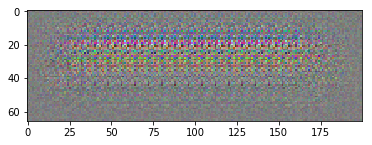

In [126]:
from scipy.misc import imsave

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img = input_img_data[0]
img = deprocess_image(img)
img = np.swapaxes(img, 1, 2)
img = np.swapaxes(img, 0, 1)
imshow(img)
imsave('./visualizations/%s_filter_%d.png' % (layer_name, filter_index), img)